In [3]:
from numpy.random import seed
seed(7532)
from tensorflow import set_random_seed
set_random_seed(7532)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

Read in the data.

In [8]:
train_set = pd.read_csv('train_set_metadata.csv')
valid_set = pd.read_csv('valid_set_metadata.csv')
test_set = pd.read_csv('test_set_metadata.csv')

train_set_partition = np.load('train_set_partition.npy')

Compute the number of parts the train set was partitioned into.

In [3]:
n_parts = len(train_set_partition) - 1
n_parts

20

## CNN Model Training from Scratch with Data Augmentation ##

In [4]:
BEST_MODEL_PATH = 'best_model.hdf5'
INPUT_SHAPE = (320, 320, 3)

LEARNING_RATE = 0.0001
N_EPOCHS = 100
BATCH_SIZE = 32

In [5]:
def create_sequential_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))    
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())  
    
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
 
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())

    model.add(Conv2D(1024, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D(2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    
    return model

In [6]:
model = create_sequential_model(INPUT_SHAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 320, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 320, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 320, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 160, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 160, 160, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 64)      18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 160, 160, 64)      256       
__________

Since our data is divided into 20 parts the network training is performed one part at a time.

Unfortunately, a technical error is causing the training to be stopped after each and every part. Howerver, the trained model does not seem to be affected.

In [ ]:
age_column_position = train_set.columns.get_loc('age')

X_valid = np.load('valid_set_hmgd_arr.npy')
y_valid = valid_set['age'].values

batch_limit = train_set_partition[1:] - train_set_partition[:-1]

for part in range(n_parts):        
#    if part < 19:
#        continue
        
    print(f'Part {part + 1}:')
    
    train_filename = 'train_set_hmgd_arr_' + str(part + 1).zfill(2) + '.npy'
    subrange = range(train_set_partition[part], train_set_partition[part + 1])    
    X_train = np.load(train_filename)
    y_train = train_set.iloc[subrange, age_column_position].values
    
    # Model initialization/loading
    if part:
        model = load_model(BEST_MODEL_PATH)
    else:
        model = create_sequential_model(X_train.shape[1:])
        adam = Adam(lr=LEARNING_RATE)
        model.compile(optimizer=adam, 
                      loss='mean_squared_error', 
                      metrics=['mean_absolute_error'])
        
        # Initialize callbacks
        checkpoint = ModelCheckpoint(BEST_MODEL_PATH, 
                                     monitor='val_loss', 
                                     save_best_only=True, 
                                     save_weights_only=False)
        
        lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.2, 
                                         patience=5)        
        
        early_stopping = EarlyStopping(monitor='val_loss', 
                                       patience=11)            
        
        callback_list = [checkpoint, 
                         lr_reduction, 
                         early_stopping]
    
    
    data_gen = ImageDataGenerator(rotation_range=20, 
                                  width_shift_range=0.2, 
                                  height_shift_range=0.2, 
                                  horizontal_flip=True)
    
    #steps_per_epoch = int(batch_limit[part] / BATCH_SIZE)
    
    model.fit_generator(data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                        steps_per_epoch=517, #steps_per_epoch, 
                        epochs=N_EPOCHS,
                        callbacks=callback_list, 
                        validation_data=(X_valid, y_valid), 
                        workers=4)
    
    
    #free up memory
    X_train = None

Part 1:
Epoch 1/100
517/517 [==============================] - 498s 963ms/step - loss: 65.0101 - mean_absolute_error: 6.1248 - val_loss: 98.1622 - val_mean_absolute_error: 7.5481
Epoch 2/100
517/517 [==============================] - 464s 898ms/step - loss: 63.0021 - mean_absolute_error: 6.0432 - val_loss: 95.6390 - val_mean_absolute_error: 7.3738
Epoch 3/100
517/517 [==============================] - 464s 898ms/step - loss: 61.9754 - mean_absolute_error: 5.9885 - val_loss: 96.5987 - val_mean_absolute_error: 7.4401
Epoch 4/100
517/517 [==============================] - 464s 898ms/step - loss: 60.5486 - mean_absolute_error: 5.9163 - val_loss: 96.1218 - val_mean_absolute_error: 7.3957
Epoch 5/100
517/517 [==============================] - 464s 898ms/step - loss: 59.0439 - mean_absolute_error: 5.8566 - val_loss: 98.2925 - val_mean_absolute_error: 7.5196
Epoch 6/100
517/517 [==============================] - 464s 898ms/step - loss: 58.6505 - mean_absolute_error: 5.8242 - val_loss: 97.7364 

**Final Model Selection**

Since our model was trained on 20 parts and was saved after each part we have in fact 20 partial models at our disposal. <br>Hence, we can select the one that produces the smallest men squared error on the validation set among, say, the last 5 <br>partial models.

In [4]:
X_valid = np.load('valid_set_hmgd_arr.npy')

In [5]:
model = load_model('best_model_age_16.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 44s 11ms/step


[97.75880964140326, 7.471387660366365]

In [6]:
model = load_model('best_model_age_17.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 39s 9ms/step


[96.73354216827744, 7.487182255448966]

In [7]:
model = load_model('best_model_age_18.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 39s 9ms/step


[96.63963116174456, 7.47352806361699]

In [8]:
model = load_model('best_model_age_19.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 40s 9ms/step


[95.44859615048229, 7.411169300590895]

In [9]:
model = load_model('best_model_age_20.hdf5')
model.evaluate(X_valid, valid_set['age'].values)

4176/4176 [==============================] - 40s 10ms/step


[94.61267168768521, 7.39665009509558]

In [10]:
# free up memory
del X_valid

Clearly, the best model is the 20th one. Now, we can read in the test data and check how this model performs on the test set.

In [4]:
X_test = np.load('test_set_hmgd_arr.npy')

In [12]:
model = load_model('best_model_age_20.hdf5')
model.evaluate(X_test, test_set['age'].values)

7621/7621 [==============================] - 73s 10ms/step


[95.94608851859395, 7.407737514569431]

Get predictions.

In [5]:
age_preds = model.predict(X_test).flatten()

In [6]:
# free up memory
del X_test

**Visual inspection of predictions and actual values**

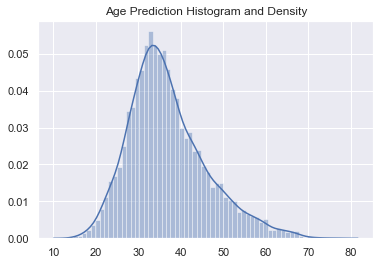

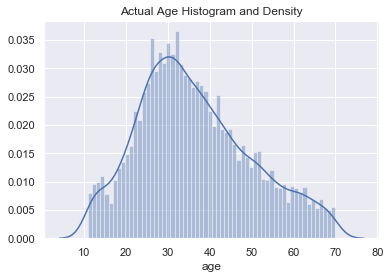

In [9]:
sns.distplot(age_preds, bins=60)
plt.title('Age Prediction Histogram and Density')
plt.show()

sns.distplot(test_set['age'], bins=60)
plt.title('Actual Age Histogram and Density')
plt.show()

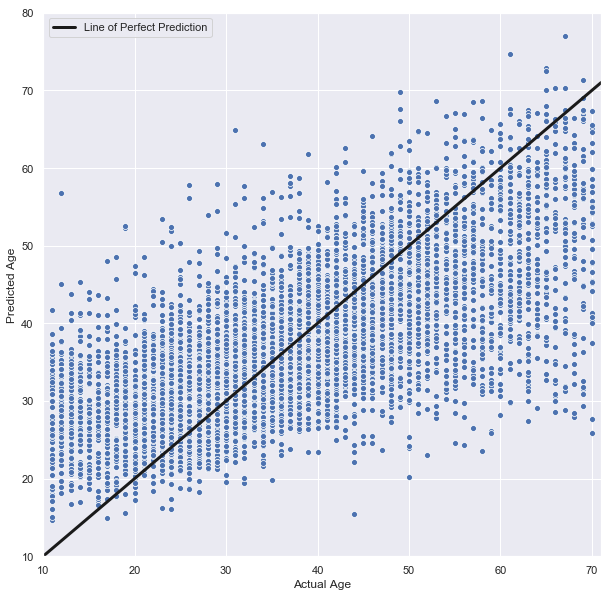

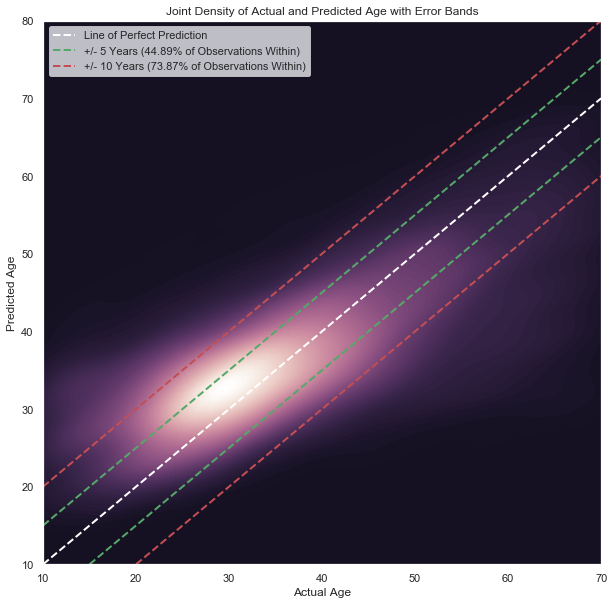

In [10]:
#Scatterplot
plt.figure(figsize=(10, 10))
plt.plot([10, 71], [10, 71], 'k', linewidth=3, label='Line of Perfect Prediction')
sns.scatterplot(test_set['age'].values, age_preds)
plt.xlim((10, 71))
plt.ylim((10, 80))
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()


#Density plot with error bands
within_5_years = (np.abs(age_preds - test_set['age'].values) <=5).mean()
within_5_years = np.round(100 * within_5_years, 2)
within_10_years = (np.abs(age_preds - test_set['age'].values) <=10).mean()
within_10_years = np.round(100 * within_10_years, 2)

plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.075, light=1, reverse=True)
sns.kdeplot(test_set['age'].values, age_preds, cmap=cmap, n_levels=100, shade=True, 
            clip=[(10, 70), (10, 80)])
plt.plot([10, 70], [10, 70], 'w--', linewidth=2, 
         label='Line of Perfect Prediction')
plt.plot([10, 70], [15, 75], 'g--', linewidth=2, 
         label=f'+/- 5 Years ({within_5_years}% of Observations Within)')
plt.plot([15, 70], [10, 65], 'g--', linewidth=2)
plt.plot([10, 70], [20, 80], 'r--', linewidth=2, 
         label=f'+/- 10 Years ({within_10_years}% of Observations Within)')
plt.plot([20, 70], [10, 60], 'r--', linewidth=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend(loc='upper left')
plt.title('Joint Density of Actual and Predicted Age with Error Bands')
plt.show()